In [1]:
# Import modules
import datetime

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy

# Clear any previously loaded kernels
spiceypy.kclear()

# Load kernels via meta file
spiceypy.furnsh('kernel_meta.txt')
print("Meta Kernel Loaded:", spiceypy.ktotal("ALL"))

# Manually load kernels (in correct order)
spiceypy.furnsh('../kernels/lsk/naif0012.tls')  # Leap Seconds
spiceypy.furnsh('../kernels/spk/de432s.bsp')    # Ephemeris Data
spiceypy.furnsh('../kernels/pck/pck00010.tpc')  # Planet Constants

# Verify total loaded kernels
print("Total Kernels Loaded:", spiceypy.ktotal("ALL"))

# We want to compute miscellaneous positions w.r.t. the centre of
# the Sun for a certain time interval.
# First, we set an initial time in UTC.
init_time_utc = datetime.datetime(year=2000, month=1, day=1, \
                                  hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
delta_days = 10000
end_time_utc = init_time_utc + datetime.timedelta(days=delta_days)

# Convert the datetime objects now to strings
init_time_utc_str = init_time_utc.strftime('%Y-%m-%dT%H:%H:%S')
end_time_utc_str = end_time_utc.strftime('%Y-%m-%dT%H:%H:%S')

# Print the starting and end times
print('Init time in UTC: %s' % init_time_utc_str)
print('End time in UTC: %s\n' % end_time_utc_str)

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
init_time_et = spiceypy.utc2et(init_time_utc_str)
end_time_et = spiceypy.utc2et(end_time_utc_str)

# Create a numpy array that covers a time interval in delta = 1 day step
time_interval_et = np.linspace(init_time_et, end_time_et, delta_days)

Meta Kernel Loaded: 1
Total Kernels Loaded: 4
Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [2]:
# Using km is not intuitive. AU would scale it too severely. Since we compute
# the Solar System Barycentre (SSB) w.r.t. the Sun; and since we expect it to
# be close to the Sun, we scale the x, y, z component w.r.t the radius of the
# Sun. We extract the Sun radii (x, y, z components of the Sun ellipsoid) and
# use the x component
_, radii_sun = spiceypy.bodvcd(bodyid=10, item='RADII', maxn=3)

radius_sun = radii_sun[0]

In [3]:
# All our computed parameters, positions etc. shall be stored in a pandas
# dataframe. First, we create an empty one
solar_system_df = pd.DataFrame()

# Set the column ET that stores all ETs
solar_system_df.loc[:, 'ET'] = time_interval_et

# The column UTC transforms all ETs back to a UTC format. The function
# spicepy.et2datetime is NOT an official part of SPICE (there you can find
# et2utc).
# However this function returns immediately a datetime object
solar_system_df.loc[:, 'UTC'] = \
    solar_system_df['ET'].apply(lambda x: spiceypy.et2datetime(et=x).date())

# Here, the position of the SSB, as seen from the Sun, is computed. Since
# spicepy.spkgps returns the position and the corresponding light time,
# we add the index [0] to obtain only the position array
solar_system_df.loc[:, 'POS_SSB_WRT_SUN'] = \
    solar_system_df['ET'].apply(lambda x: spiceypy.spkgps(targ=0, \
                                                          et=x, \
                                                          ref='ECLIPJ2000', \
                                                          obs=10)[0])

# Now the SSB position vector is scaled with the Sun's radius
solar_system_df.loc[:, 'POS_SSB_WRT_SUN_SCALED'] = \
    solar_system_df['POS_SSB_WRT_SUN'].apply(lambda x: x / radius_sun)

# Finally the distance between the Sun and the SSB is computed. The length
# (norm) of the vector needs to be determined with the SPICE function vnorm().
# numpy provides an identical function in: numpy.linalg.norm()
solar_system_df.loc[:, 'SSB_WRT_SUN_SCALED_DIST'] = \
    solar_system_df['POS_SSB_WRT_SUN_SCALED'].apply(lambda x: \
                                                    spiceypy.vnorm(x))

In [4]:
# We define a dictionary with a planet's barycentre abbreviation and corresponding NAIF ID code
NAIF_ID_DICT = {'JUP': 5, \
                'SAT': 6}

# Iterate through the dictionary and compute the position vector for each
# planet as seen from the Sun. Further, compute the phase angle between the
# SSB and the planet as seen from the Sun
for planets_name_key in NAIF_ID_DICT:

    # Define the pandas dataframe column for each planet (position and phase
    # angle). Each '%s' substring is replaced with the planets name as
    # indicated after the "%"
    planet_pos_col = f"POS_{planets_name_key}_WRT_SUN"
    planet_angle_col = f"PHASE_ANGLE_SUN_{planets_name_key}2SSB"

    # Get the corresponding NAIF ID of the planet's barycentre
    planet_id = NAIF_ID_DICT[planets_name_key]

    # Compute the planet's position as seen from the Sun.
    solar_system_df.loc[:, planet_pos_col] = \
        solar_system_df['ET'].apply(lambda x: \
                                    spiceypy.spkgps(targ=planet_id, \
                                                    et=x, \
                                                    ref='ECLIPJ2000', \
                                                    obs=10)[0])

    # Compute the phase angle between the SSB and the planet as seen from the
    # Sun. Since we apply a lambda function on all columns we need to set
    # axis=1, otherwise we get an error!
    solar_system_df.loc[:, planet_angle_col] = \
        solar_system_df.apply(lambda x: \
                              np.degrees(spiceypy.vsep(x[planet_pos_col], \
                                                       x['POS_SSB_WRT_SUN'])), \
                              axis=1)

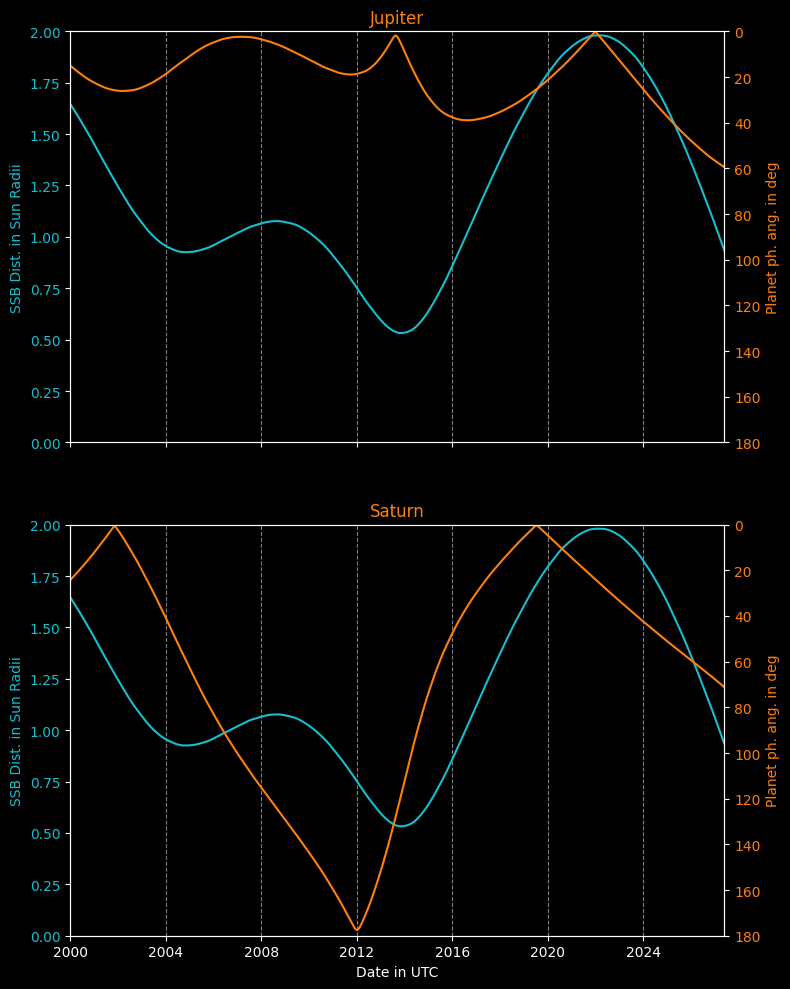

In [5]:
# Set a dark mode, since it's fancy
plt.style.use('dark_background')

# Create a 2 axes plot where all 2 plots are vertically aligned and share the
# x axis (date in UTC)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

# We iterate through the planets (from Jupiter to Neptune) and plot the
# phase angle between the planet and the SSB, as seen from the Sun, in each
# axis individually
for ax_f, planet_abr, planet_name in zip([ax1, ax2], \
                                         ['JUP', 'SAT'], \
                                         ['Jupiter', 'Saturn']):

    # First, we set the planet's name as the sub plot title (instead of
    # setting a legend)
    ax_f.set_title(planet_name, color='tab:orange')

    # The distance between the SSB and the Sun is plotted.
    ax_f.plot(solar_system_df['UTC'], \
              solar_system_df['SSB_WRT_SUN_SCALED_DIST'], \
              color='tab:cyan')

    # A y label is set and the color of labels and ticks are adjusted for
    # better visibility
    ax_f.set_ylabel('SSB Dist. in Sun Radii', color='tab:cyan')
    ax_f.tick_params(axis='y', labelcolor='tab:cyan')

    # Set x (based on the min and max date) and y limits (the SSB has varying
    # distances between 0 and 2 Sun Radii)
    ax_f.set_xlim(min(solar_system_df['UTC']), max(solar_system_df['UTC']))
    ax_f.set_ylim(0, 2)

    # We add now the phase angle values and copy the x axis for this purpose
    ax_f_add = ax_f.twinx()

     # Plot the phase angle between the SSB and planet as seen from the Sun
    ax_f_add.plot(solar_system_df['UTC'], \
                  solar_system_df[f'PHASE_ANGLE_SUN_{planet_abr}2SSB'], \
                  color='tab:orange', \
                  linestyle='-')

    # Set the y label's name and color accordingly
    ax_f_add.set_ylabel('Planet ph. ang. in deg', color='tab:orange')
    ax_f_add.tick_params(axis='y', labelcolor='tab:orange')

    # Invert the y axis and set the limits. We invert the axis so that a
    # possible anti-correlation (large phase angle corresponds to a smaller
    # distance between the Sun's centre and the SSB) becomes more obvious
    ax_f_add.invert_yaxis()
    ax_f_add.set_ylim(180, 0)

    # Set a grid (only date)
    ax_f.grid(axis='x', linestyle='dashed', alpha=0.5)


# Finally we set the x label ...
ax2.set_xlabel('Date in UTC')

# ... tight the figures a bit ...
fig.tight_layout()

# ... reduce the distance between the axes ...
plt.subplots_adjust(hspace=0.2)

# ... and save the figure in high quality
plt.savefig('PLANETS_SUN_SSB_PHASE_ANGLE.png', dpi=300)